# Aprendizagem por reforço (Reinforcement learning) - Lunar Lander


[Revisão parte do Projeto de Pesquisa Aplicada de Raphael Garcia Moreira](https://www.linkedin.com/in/raphaelgarciamoreira/)


- from tensorflow.keras import Sequential:

Sequential é uma classe em Keras (parte do TensorFlow) usada para criar modelos de aprendizado profundo (redes neurais) de maneira sequencial. Cada camada é adicionada uma após a outra, e o modelo é construído camada por camada.

- from tensorflow.keras.layers import Dense, Input:

Dense é uma camada em Keras usada para criar camadas totalmente conectadas em uma rede neural. Cada neurônio na camada está conectado a todos os neurônios da camada subsequente.
Input é uma camada especial usada para definir a entrada da rede neural. Ela é necessária ao criar modelos mais complexos com várias entradas.

- from tensorflow.keras.losses import MSE:

MSE (Mean Squared Error) é uma função de perda em Keras usada para medir a diferença média quadrática entre os valores preditos e os valores reais durante o treinamento de uma rede neural. É comumente usada em problemas de regressão.

- from tensorflow.keras.optimizers import Adam:

Adam é um otimizador em Keras que implementa o algoritmo de otimização Adam. O otimizador é responsável por ajustar os pesos da rede neural durante o treinamento para minimizar a função de perda.

- import base64:

base64 é um módulo que fornece funções para codificar e decodificar dados usando o esquema de codificação base64. É comumente usado para representar dados binários em formato de texto, útil em comunicação de dados na web.

- import random:

random é um módulo que fornece funções relacionadas à geração de números aleatórios. Pode ser usado para embaralhar listas, escolher elementos aleatórios, entre outras operações relacionadas a aleatoriedade.

- from itertools import zip_longest:

zip_longest é uma função do módulo itertools que permite agrupar elementos de iteráveis de comprimentos diferentes. Ela preenche os valores ausentes com um valor específico (por padrão, None).

- import imageio:

imageio é uma biblioteca para leitura e escrita de imagens em diferentes formatos. É frequentemente usada em processamento de imagem e computação visual.

- import IPython:

IPython é uma poderosa interface interativa para programação em Python. Fornece recursos aprimorados em comparação com o interpretador Python padrão, como a capacidade de executar células de código interativamente.

- import matplotlib.pyplot as plt:

matplotlib.pyplot é uma biblioteca de visualização que fornece funções para criar gráficos e visualizações. O plt é frequentemente usado como um alias para facilitar o acesso às funções desta biblioteca.

- import matplotlib.ticker as mticker:

matplotlib.ticker é um módulo dentro do matplotlib que fornece classes e funções relacionadas à formatação de marcações em eixos de gráficos.

- import pandas as pd:

pandas é uma biblioteca popular para manipulação e análise de dados em Python. O pd é frequentemente usado como um alias para facilitar o acesso às funções desta biblioteca.

In [1]:
import pandas as pd
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import IPython
import imageio
from itertools import zip_longest
import random
import base64
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from pyvirtualdisplay import Display
import tensorflow as tf
import time
from collections import deque, namedtuple
'''
collections.deque:
O módulo collections fornece a classe deque (double-ended queue), que é uma
estrutura de dados de fila (queue) otimizada para operações rápidas tanto no início
quanto no final. Em outras palavras, é uma fila em que você pode adicionar e remover
elementos tanto na frente quanto na parte de trás de maneira eficiente.


collections.namedtuple:
namedtuple é uma função para criar subclasses de tuplas com campos nomeados.
Ela retorna uma nova classe que pode ser usada para criar instâncias de tuplas
nomeadas. Isso é útil quando você deseja dar nomes significativos aos elementos
em uma tupla, tornando o código mais legível.
'''

import gym
import numpy as np
import PIL.Image
'''
O PIL.Image é usado para manipulação de imagens e fornece uma variedade de funcionalidades,
como abrir, manipular e salvar diferentes formatos de imagens. Ele oferece uma classe 
chamada Image que representa uma imagem e fornece métodos para realizar operações como 
redimensionamento, rotação, conversão de formato, entre outras.
'''


# pyvirtualdisplay é uma biblioteca que permite criar displays virtuais em Python.

2024-01-05 18:19:24.375267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 0  # Semente para pseudo-gerador de números aleatórios
MINIBATCH_SIZE = 64
# Parametros de atualização: w_target = (TAU * w) + (1 - TAU) * w_target
TAU = 1e-3
E_DECAY = 0.995
'''
A taxa de decaimento (decay rate) ε em uma política
ε-greedy refere-se à redução gradual do valor de ε ao longo
do tempo durante o treinamento de um agente de aprendizado por reforço.
'''
E_MIN = 0.01  # Valor mínimo de ε

random.seed(SEED)

# Definição da semente aleatória para TensorFlow
tf.random.set_seed(SEED)

# Configura um display para renderizar o ambiente do Lunar Lander.
Display(visible=0, size=(840, 480)).start()

## Definição dos hyperparâmetros

In [3]:
MEMORY_SIZE = 100_000     # Tamanho da memória do buffer
GAMMA = 0.995             # Fator de desconto
ALPHA = 1e-3              # Taxa de aprendizado
NUM_STEPS_FOR_UPDATE = 4  # Atualização do aprendizado a cada NUM_STEPS_FOR_UPDATE

## Ambiente Lunar Lander

Por favor, coloque no formato de Markdown para ser copiado para o VSCode:
Neste notebook, usaremos a [Biblioteca Gym da OpenAI](https://gymnasium.farama.org/), que oferece ambientes para aprendizado por reforço. Um ambiente representa um problema a ser resolvido. Vamos resolver o ambiente Lunar Lander, onde o objetivo é pousar a nave lunar com segurança na plataforma da lua, marcada por duas bandeiras, e seu centro está em (0,0). A nave pode pousar fora da plataforma, inicia no topo com uma força inicial aleatória no centro de massa e tem combustível infinito. O ambiente é considerado resolvido ao alcançar 200 pontos.

### Ações no espaço

* Não faça nada (Do nothing).
* Ligue o motor direito (Fire right engine).
* Ligue o motor principal (Fire main engine).
* Ligue o motor esquerdo (Fire left engine).

As constantes no código ficam:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

### Métricas

* As coordenadas $(x,y)$. A coordenada de aterrisagem é $(0,0)$.
* Velocidades $(\dot x,\dot y)$.
* Ângulo $\theta$.
* Velocidade ângular $\dot \theta$.
* Dois booleanos, $l$ e $r$, que representa cada trem de pouso da nave.

### Recompensas

Após cada passo, uma recompensa é concedida. A recompensa total de um episódio é a soma das recompensas para todos os passos dentro desse episódio.

Para cada passo, a recompensa:

é aumentada/diminuída quanto mais perto/longe o lander estiver da plataforma de pouso.
é aumentada/diminuída quanto mais devagar/mais rápido o lander estiver se movendo.
é diminuída quanto mais inclinado o lander estiver (ângulo não horizontal).
é aumentada em 10 pontos para cada perna em contato com o solo.
é diminuída em 0.03 pontos a cada quadro em que o motor lateral está ativado.
é diminuída em 0.3 pontos a cada quadro em que o motor principal está ativado.
O episódio recebe uma recompensa adicional de -100 ou +100 pontos por colisão ou pouso seguro, respectivamente.

### Definição de Game Over

Um episódio termina (ou seja, o ambiente entra em estado terminal) se:

* O módulo lunar cai (ou seja, se o corpo do módulo lunar entrar em contato com a superfície da lua).

* O valor absoluto da coordenada $x$ do módulo de pouso é maior que 1 (ou seja, vai além da borda esquerda ou direita)

## Carregando o ambiente `LunarLander-v2`



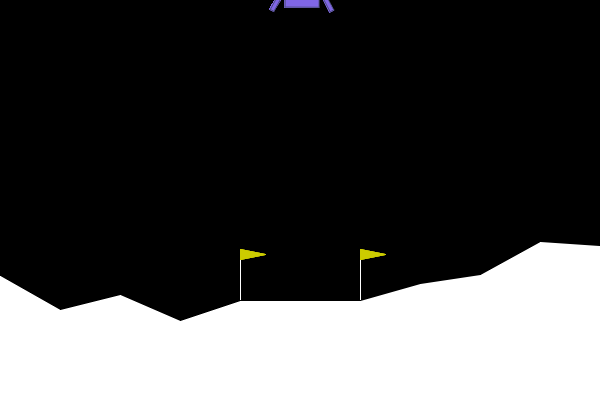

In [4]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset()  # Este método reseta o ambiente para o estado inicial
# Mostra o primeiro frame do ambiente reiniciado
PIL.Image.fromarray(env.render())

Observe que vamos precisar construir uma rede neural, então precisamos saber o tamanho do vetor de estado e o número de ações possíveis.
Para fazer isso podemos usar os métodos `.observation_space.shape` e `action_space.n`.

In [5]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('A forma ou shape da variável state_size:', state_size)
print('Número de ações:', num_actions)

# Este método reseta o ambiente para o estado inicial. O '[0]' é necessário na versão do gym 0.26.2
current_state = env.reset()[0]
print(gym.__version__)

A forma ou shape da variável state_size: (8,)
Número de ações: 4
0.26.2


## Interação com a biblioteca Gym:

A biblioteca Gym segue o formalismo “agent-environment loop”, veja o link da documentação abaixo da figura:

<p align="left">
  <img src="https://www.gymlibrary.dev/_images/AE_loop.png" alt="Interagindo com o Meio Ambiente" width="450">
</p>

[Link para Gym Documentation.](https://www.gymlibrary.dev/content/basic_usage/)

In [6]:
def display_table(current_state, action, next_state, reward, done):

    STATE_VECTOR_COL_NAME = 'Vetor de Estado'
    DERIVED_COL_NAME = 'Deriva do Vetor de Estado (Quanto mais próximo de zero, melhor é)'

    def add_derived_info(state): return np.hstack([
        state,
        [(state[0]**2 + state[1]**2)**.5],
        [(state[2]**2 + state[3]**2)**.5],
        [np.abs(state[4])]
    ])

    modified_current_state = add_derived_info(current_state)
    modified_next_state = add_derived_info(next_state)

    states = np.vstack([
        modified_current_state,
        modified_next_state,
        modified_next_state - modified_current_state,
    ]).T

    def get_state(idx, type=np.float32): return dict(zip(
        ['Estado atual', 'Próximo estado'],
        states[idx].astype(type)
    ))

    action_labels = [
        "Fique parado",
        "Ligue o motor da direita",
        "Ligue o motor principal",
        "Ligue o motor da esquerda",
    ]

    display(
        pd.DataFrame({
            ('', '', ''): {'Ação': action_labels[action], 'Recompensa': reward, 'Episódio concluído': done},
            (STATE_VECTOR_COL_NAME, 'Coordenada', 'X (Horizontal)'): get_state(0),
            (STATE_VECTOR_COL_NAME, 'Coordenada', 'Y (Vertical)'): get_state(1),
            (STATE_VECTOR_COL_NAME, 'Velocidade', 'X (Horizontal)'): get_state(2),
            (STATE_VECTOR_COL_NAME, 'Velocidade', 'Y (Vertical)'): get_state(3),
            (STATE_VECTOR_COL_NAME, 'Inclinação', 'Angle'): get_state(4),
            (STATE_VECTOR_COL_NAME, 'Inclinação', 'Velocidade angular'): get_state(5),
            (STATE_VECTOR_COL_NAME, 'Aterrizado', 'Trem de pouso esquerdo?'): get_state(6, np.bool),
            (STATE_VECTOR_COL_NAME, 'Aterrizado', 'Trem de pouso direito?'): get_state(7, np.bool),
            (DERIVED_COL_NAME, 'Distância do ponto ideal de Aterrissagem', ''): get_state(8),
            (DERIVED_COL_NAME, 'Velocidade', ''): get_state(9),
            (DERIVED_COL_NAME, 'Angulo de inclinação (valor absoluto)', ''): get_state(10),
        })
        .fillna('')
        .reindex(['Estado atual', 'Ação', 'Próximo estado', 'Recompensa', 'Episódio concluído'])
        .style
        .applymap(lambda x: 'background-color: darkblue' if x == '' else '')
        .set_table_styles(
            [
                {"selector": "th", "props": [
                    ("border", "1px solid blue"), ('text-align', 'center')]},
                {"selector": "tbody td", "props": [
                    ("border", "1px solid blue"), ('text-align', 'center')]},
            ]
        )
    )

In [7]:
action = 0  # Selecione a ação 0: Do nothing

next_state, reward, done, _, _ = env.step(
    action)  # Execute a ação e receba os dados

display_table(current_state, action, next_state,
              reward, done)  # Mostre os valores obtidos

current_state = next_state

print('\n\nValor de next_state (Compare com a tabela acima):', next_state)
print('\nO shape de next_state (Compare com a tabela acima):', next_state.shape)

/tmp/ipykernel_25575/723136630.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (STATE_VECTOR_COL_NAME, 'Aterrizado', 'Trem de pouso esquerdo?'): get_state(6, np.bool),
/tmp/ipykernel_25575/723136630.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (STATE_VECTOR_COL_NAME, 'Aterrizado', 'Trem de pouso direito?'): get_state(7, np.bool),




Valor de next_state (Compare com a tabela acima): [-0.00602436  1.407765   -0.30468497 -0.08295389  0.00691188  0.06830588
  0.          0.        ]

O shape de next_state (Compare com a tabela acima): (8,)


## Deep Q-Learning


A letra "Q" em Deep Q-Learning refere-se à função valor-ação, que é fundamental nesse tipo de algoritmo de aprendizado por reforço. A função Q (Q-function) representa a qualidade de tomar uma determinada ação em um determinado estado em um problema de tomada de decisão sequencial, como os modelados por processos de decisão de Markov (MDPs).

Nos casos em que o espaço de estado e de ação são discretos, podemos estimar a função valor-ação iterativamente usando a equação de Bellman:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

Este método iterativo converge para a função de valor de ação ideal $Q^*(s,a)$ como $i\to\infty$. Isso significa que o agente só precisa explorar gradualmente o espaço estado-ação e continuar atualizando a estimativa de $Q(s,a)$ até que ela convirja para a função ótima de valor de ação $Q^*(s,a)$. Contudo, nos casos em que o espaço de estados é contínuo torna-se praticamente impossível explorar todo o espaço de ação dos estados. Consequentemente, isso também torna praticamente impossível estimar gradualmente $Q(s,a)$ até convergir para $Q^*(s,a)$.

No Deep $Q$-Learning, resolvemos esse problema usando uma rede neural para estimar a função de valor de ação $Q(s,a)\approx Q^*(s,a)$. Chamamos essa rede neural de rede $Q$ e ela pode ser treinada ajustando seus pesos a cada iteração para minimizar o erro quadrático médio na equação de Bellman.

Infelizmente, o uso de redes neurais na aprendizagem por reforço para estimar funções de valor de ação provou ser altamente instável. Felizmente, existem algumas técnicas que podem ser empregadas para evitar instabilidades. Essas técnicas consistem no uso de uma ***Target Network*** e ***Experience Replay***. Exploraremos essas duas técnicas nas seções a seguir.

## Target Network

Podemos treinar a rede $Q$ ajustando seus pesos a cada iteração para minimizar o erro quadrático médio na equação de Bellman, onde os valores alvo são dados por:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

onde $w$ são os pesos da rede $Q$. Isso significa que estamos ajustando os pesos $w$ a cada iteração para minimizar o seguinte erro:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\ rm {Erro}}
$$

Observe que isso é um problema porque o alvo $y$ muda a cada iteração. Ter um alvo em constante movimento pode levar a oscilações e instabilidades. Para evitar isso, podemos criar
uma rede neural separada para gerar os alvos $y$. Chamamos essa rede neural separada de **target $\hat Q$-Network** e ela terá a mesma arquitetura da $Q$-Network original. Ao usar o alvo $\hat Q$-Network, o erro acima se torna:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a; w)}^{\rm {Erro}}
$$

onde $w^-$ e $w$ são os pesos do alvo $\hat Q$-Network e $Q$-Network, respectivamente.

Na prática, usaremos o seguinte algoritmo: a cada passo de tempo $C$ usaremos a rede $\hat Q$ para gerar os alvos $y$ e atualizaremos os pesos do alvo $\hat Q$-Rede usando o pesos da rede $Q$. Atualizaremos os pesos $w^-$ da $\hat Q$-Network de destino usando uma **soft update**. Isso significa que atualizaremos os pesos $w^-$ usando a seguinte regra:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

onde $\tau\ll 1$. Ao usar a atualização suave, garantimos que os valores alvo, $y$, mudem lentamente, o que melhora muito a estabilidade do nosso algoritmo de aprendizagem. Veja que definimos um valor `TAU` no código acima com valor $\tau\ll 1$.

In [8]:
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

optimizer = Adam(learning_rate=ALPHA)

2024-01-05 18:19:48.312536: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Experience Replay

Quando nosso "agente" (pode pensar nele como um robô ou personagem em um jogo) está interagindo com o ambiente ao seu redor, ele passa por diferentes situações chamadas de "estados", toma decisões chamadas de "ações" e recebe feedbacks chamados de "recompensas". O problema é que essas experiências acontecem em uma sequência, uma após a outra, e podem estar fortemente relacionadas.

Imagine se tentássemos aprender apenas com essas experiências sequenciais. Poderíamos enfrentar problemas devido às fortes conexões entre elas. Para contornar isso, usamos uma técnica chamada Experience Replay (Repetição da Experiência).

O que fazemos é armazenar essas experiências do agente, ou seja, as situações em que ele estava, as decisões que tomou e as recompensas que recebeu, em uma espécie de "memória". As tuplas de experiência $(S_t, A_t, R_t, S_{t+1})$ serão adicionadas ao buffer de memória a cada passo de tempo conforme o agente interage com o ambiente.

Essa memória é como um baú onde guardamos essas informações. E, ao invés de aprender com as experiências de forma sequencial, fazemos algo um pouco diferente.

Nós pegamos pequenos grupos aleatórios dessas experiências (como amostrar aleatoriamente pedaços de uma história) e usamos esses pedaços para ensinar nosso agente. Isso é como assistir a trechos de um filme ao invés de ver a história toda de uma vez.

Essa abordagem nos ajuda a evitar problemas que poderiam surgir se apenas seguíssemos a ordem cronológica das experiências. As tuplas de experiência, que incluem o estado atual, a ação tomada, a recompensa recebida e o próximo estado, são adicionadas ao baú de memória à medida que o agente explora o ambiente.

In [9]:
experience = namedtuple("Experience", field_names=[
                        "state", "action", "reward", "next_state", "done"])

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{se o episódio terminar no ponto  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{senão}\\
    \end{cases}       
\end{equation}
$$

In [10]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calcula a função perda (loss).

    Args:
      experiences: ["state", "action", "reward", "next_state", "done"]
      gamma: (float) O fator de desconto.
      q_network: (tf.keras.Sequential) Modelo keras para prever q_values
      target_q_network: (tf.keras.Sequential) Modelo keras para prever targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) O MSE (Mean-Squared Error) entre
            os alvos (targets) y e os valores Q(s,a).
    """

    states, actions, rewards, next_states, done_vals = experiences

    # Calcula o valor max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # y = R se o episódio terminar, senão y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Obtenha os q_values e remodele para corresponder aos y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    loss = MSE(y_targets, q_values)

    return loss

## Atualizar os pesos da rede (Aprendizado)

In [11]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights +
                              (1.0 - TAU) * target_weights)

In [12]:
'''
A anotação @tf.function é usada no início dessa função para converter a função Python em um grafo TensorFlow compilado.

Desempenho: O TensorFlow usa um mecanismo chamado grafo computacional para otimizar o desempenho.
            Converter a função para um grafo permite que o TensorFlow aplique diversas otimizações,
            como a execução de operações em paralelo, fusão de operações e outras técnicas para
            melhorar a eficiência computacional.

GPU e TPU: Funções anotadas com @tf.function podem ser executadas de forma mais eficiente em unidades
            de processamento gráfico (GPU) e unidades de processamento tensorial (TPU).
            Isso é crucial para tarefas que envolvem aprendizado profundo, onde essas unidades de
            processamento especializadas podem acelerar significativamente os cálculos.

Economia de Recursos: Uma vez que a função é convertida em um grafo, ela pode ser reutilizada sem
            a sobrecarga associada à reinterpretação do código Python a cada chamada.
            Isso economiza recursos computacionais e melhora a eficiência.

Compatibilidade com TensorFlow: Funções anotadas com @tf.function são compatíveis com as funcionalidades
            específicas do TensorFlow, como a capacidade de salvar e carregar modelos,
            facilitando a integração com outras partes da biblioteca.
'''


@tf.function
def agent_learn(experiences, gamma):
    """
    Atualiza os pesos da Q networks.

    Args:
      experiences: (tuple) ["state", "action", "reward", "next_state", "done"]
      gamma: (float) Fator desconto.

    """

    # Calcula a perda (loss)
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Obtenha os gradientes da perda em relação aos pesos.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Atualize os pesos do q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # Atualize os pesos do alvo q_network
    update_target_network(q_network, target_q_network)

## Treinamento do agente

In [13]:
def get_action(q_values, epsilon=0.0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))


def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]
                 ).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)


def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY * epsilon)

In [14]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # número total de pontos a serem usados para calcular a média
epsilon = 1.0     # valor ε inicial para política ε-greedy

# Crie um buffer de memória D com capacidade N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Defina os pesos da rede de destino iguais aos pesos da Q-Network
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Redefina o ambiente para o estado inicial e obtenha o estado inicial
    state = env.reset()[0]
    total_points = 0

    for t in range(max_num_timesteps):

        # A partir do estado atual S, escolha uma ação A usando uma política ε-greedy
        # state precisa ter o formato correto para q_network
        state_qn = np.expand_dims(state, axis=0)
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Execute a ação A e receba a recompensa R e o próximo estado S'
        next_state, reward, done, _, _ = env.step(action)

        # Armazena a tupla de experiência (S,A,R,S') no buffer de memória.
        # Também armazenamos a variável done por conveniência.
        memory_buffer.append(experience(
            state, action, reward, next_state, done))

        # Atualize a rede apenas a cada NUM_STEPS_FOR_UPDATE intervalos de tempo.
        update = check_update_conditions(
            t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Amostra de minilote aleatório de tuplas de experiência (S,A,R,S') de D
            experiences = get_experiences(memory_buffer)

            # Defina os alvos y, execute uma etapa de descida gradiente,
            # e atualize os pesos da rede.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Atualize o valor ε
    epsilon = get_new_eps(epsilon)

    print(
        f"\rEpisódio {i+1} | Média total de pontos do último {num_p_av} episódios: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(
            f"\rEpisódio {i+1} | Média total de pontos do último {num_p_av} episódios: {av_latest_points:.2f}")

    # Consideraremos que o meio ambiente está resolvido se conseguirmos uma
    # média de 200 pontos nos últimos 100 episódios.
    if av_latest_points >= 200.0:
        print(f"\n\nAmbiente resolvido em {i+1} episódios!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTempo de execução total: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episódio 100 | Média total de pontos do último 100 episódios: -159.87
Episódio 200 | Média total de pontos do último 100 episódios: -99.539
Episódio 300 | Média total de pontos do último 100 episódios: -83.859
Episódio 400 | Média total de pontos do último 100 episódios: 1.9577
Episódio 500 | Média total de pontos do último 100 episódios: 137.53
Episódio 600 | Média total de pontos do último 100 episódios: 189.03
Episódio 618 | Média total de pontos do último 100 episódios: 202.46

Ambiente resolvido em 618 episódios!

Tempo de execução total: 1557.57 s (25.96 min)


In [15]:
def plot_history(point_history, **kwargs):
    lower_limit = 0
    upper_limit = len(point_history)

    window_size = (upper_limit * 10) // 100

    plot_rolling_mean_only = False
    plot_data_only = False

    if kwargs:
        if "window_size" in kwargs:
            window_size = kwargs["window_size"]

        if "lower_limit" in kwargs:
            lower_limit = kwargs["lower_limit"]

        if "upper_limit" in kwargs:
            upper_limit = kwargs["upper_limit"]

        if "plot_rolling_mean_only" in kwargs:
            plot_rolling_mean_only = kwargs["plot_rolling_mean_only"]

        if "plot_data_only" in kwargs:
            plot_data_only = kwargs["plot_data_only"]

    points = point_history[lower_limit:upper_limit]

    episode_num = [x for x in range(lower_limit, upper_limit)]

    rolling_mean = pd.DataFrame(points).rolling(window_size).mean()

    plt.figure(figsize=(10, 7), facecolor="white")

    if plot_data_only:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
    elif plot_rolling_mean_only:
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")
    else:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")

    text_color = "black"

    ax = plt.gca()
    ax.set_facecolor("black")
    plt.grid()
    plt.xlabel("Episódio", color=text_color, fontsize=30)
    plt.ylabel("Total de pontos", color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter("{x:,}")
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis="x", colors=text_color)
    ax.tick_params(axis="y", colors=text_color)
    plt.show()

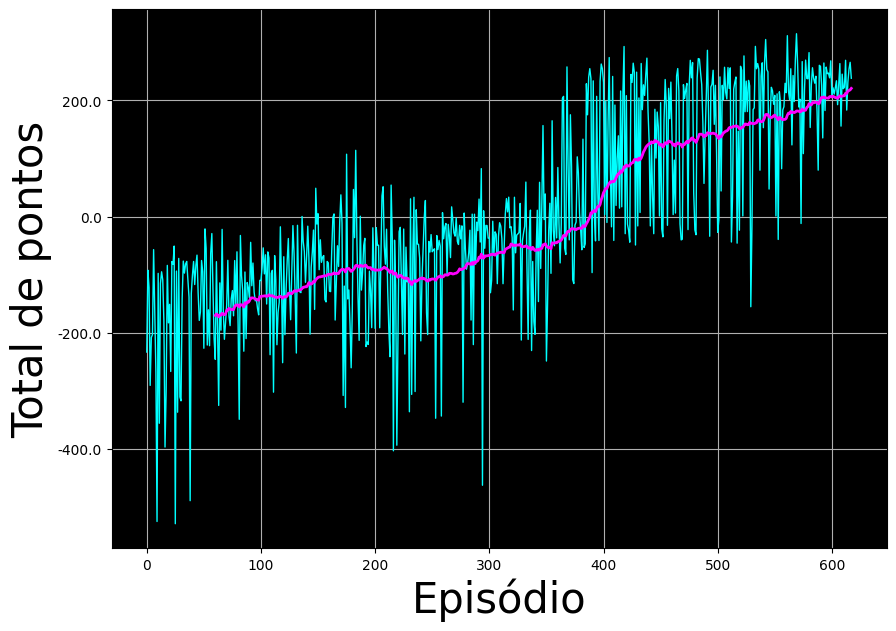

In [16]:
plot_history(total_point_history)

In [17]:
import logging
logging.getLogger().setLevel(logging.ERROR)
'''
import logging: Importa o módulo logging em Python,
                que fornece funcionalidades para registrar mensagens de log.

logging.getLogger(): Obtém o objeto logger padrão.
                    O logger é responsável por emitir as mensagens de log.

setLevel(logging.ERROR): Define o nível de log para o nível de erro (ERROR).
                        O nível de log controla o tipo de mensagens que serão registradas.
                        O nível de erro (ERROR) é um dos níveis mais altos, o que significa 
                        que apenas mensagens de erro e níveis mais críticos serão registradas.
'''

'\nimport logging: Importa o módulo logging em Python,\n                que fornece funcionalidades para registrar mensagens de log.\n\nlogging.getLogger(): Obtém o objeto logger padrão.\n                    O logger é responsável por emitir as mensagens de log.\n\nsetLevel(logging.ERROR): Define o nível de log para o nível de erro (ERROR).\n                        O nível de log controla o tipo de mensagens que serão registradas.\n                        O nível de erro (ERROR) é um dos níveis mais altos, o que significa \n                        que apenas mensagens de erro e níveis mais críticos serão registradas.\n'

In [18]:
def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False

        state = env.reset()[0]
        frame = env.render()

        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _, _ = env.step(action)
            frame = env.render()

            video.append_data(frame)


def embed_mp4(filename):
    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )
    return IPython.display.HTML(tag)

In [19]:
filename = "./videos/lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)

[swscaler @ 0x6846540] Warning: data is not aligned! This can lead to a speed loss


## Referências

[Gymnasium](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

[OpenAI](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py)

[Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)

[Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236?source=post_page---------------------------)